In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})
# %matplotlib widget


In [38]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

In [39]:
########## importing and testing the file
FITS1 = '../FITS_file/CygX_E_OTFMAP.fits'
FITS2 = '../FITS_file/DR21_NH2_Repr.fits'
FITS3 = '../FITS_file/DR21_Tdust_Repr.fits'
FITS4 = '../FITS_file/DR21_IRAC4_Repr.fits'
FITS5 = '../FITS_file/DR21_Her250_Repr.fits'
hdul = fits.open(FITS1)
hdul2 = fits.open(FITS2)
hdul3 = fits.open(FITS3)
hdul4 = fits.open(FITS4)
hdul5 = fits.open(FITS5)
print(hdul5.info())

MapStokesI = hdul[0]
MapStokesIError = hdul[1]

MapStokesQ = hdul[2]
MapStokesU = hdul[4]
MapDebPol = hdul[8]
MapDebPolError = hdul[9]
MapPolAngleNonRotated = hdul[10]
MapPolAngle = hdul[11]
MapPolAngleError = hdul[12]
MapPolFlux = hdul[13]
MapPolFluxError = hdul[14]
MapColumndensity = hdul2[0]
MapTemperature = hdul3[0]
Map8Micron = hdul4[0]
MapHer250 = hdul5[0]

MapPolSNR = MapDebPol.copy()
BlankedMapPol = MapDebPol.copy()
BlankedMapPolError= MapDebPolError.copy()
BlankedMapPolAngle = MapPolAngle.copy()
BlankedMapPolAngleError = MapPolAngleError.copy()
BlankedMapStokesI = MapStokesI.copy()
BlankedMapStokesQ = MapStokesQ.copy()
BlankedMapStokesU = MapStokesU.copy()
BlankedMapColumnDensity = MapColumndensity.copy()
BlankedMapTemperature = MapTemperature.copy()
BlankedMapPolAngleNonRotated = MapPolAngleNonRotated.copy() 
BlankedMap8Mircon = Map8Micron.copy()
BlankedMapHer250 = MapHer250.copy()

######## taking points only with singal to noise ratio more than 3
MapPolSNR.data[:] = np.nan
MapPolSNR.data = MapDebPol.data/MapDebPolError.data
Selector = (MapPolSNR.data < 3)

BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan
# BlankedMapHer250.data[Selector] = np.nan

Selector = (BlankedMapPol.data>50)
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# BlankedMapHer250.data[Selector] = np.nan


Selector = MapStokesI.data/MapStokesIError.data < 25
BlankedMapPol.data[Selector] = np.nan
BlankedMapPolAngle.data[Selector] = np.nan
BlankedMapPolAngleError.data[Selector] = np.nan
BlankedMapStokesI.data[Selector] = np.nan
BlankedMapStokesQ.data[Selector] = np.nan
BlankedMapStokesU.data[Selector] = np.nan
BlankedMapPolAngleNonRotated.data[Selector] = np.nan
BlankedMapColumnDensity.data[Selector] = np.nan
BlankedMapTemperature.data[Selector] = np.nan
BlankedMap8Mircon.data[Selector] = np.nan
BlankedMapPolError.data[Selector] = np.nan

# BlankedMapHer250.data[Selector] = np.nan

BlankedMapColumnDensity.data = BlankedMapColumnDensity.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapTemperature.data = BlankedMapTemperature.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMap8Mircon.data = BlankedMap8Mircon.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
BlankedMapPolAngleError.data = BlankedMapPolAngleError.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)
# BlankedMapHer250.data = BlankedMapHer250.data*(BlankedMapStokesI.data/BlankedMapStokesI.data)



############## generating the RA and DEC mesh
DEC_grid,RA_grid = generate_RA_DEC_mesh(hdul[0])
seperation = MapPolAngle.copy()

# plt.figure()
# plt.imshow(BlankedMapStokesI.data,origin='lower',vmin = 1,vmax = 45)
# plt.show()

Filename: ../FITS_file/DR21_Her250_Repr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU    1094   (110, 93)   float64   
None


In [40]:

set_delta = 0.5   # in arcminute
S_map = BlankedMapPolAngle.copy()
sigma_S_map = BlankedMapPolAngleError.copy()

for i in range(RA_grid.shape[0]):
    for j in range(RA_grid.shape[1]):

        ##### seperation filter
        seperation.data = Calc_l(RA_grid[i,j],DEC_grid[i,j],RA_grid,DEC_grid)
        seperation_selector = (seperation.data<0.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data>1.5*set_delta)
        seperation.data[seperation_selector] = np.nan
        seperation_selector = (seperation.data >0)

        ##### making the dispersion map
        tempa = BlankedMapStokesQ.data*BlankedMapStokesU.data[i,j] - BlankedMapStokesQ.data[i,j]*BlankedMapStokesU.data
        tempb = BlankedMapStokesQ.data*BlankedMapStokesQ.data[i,j] + BlankedMapStokesU.data*BlankedMapStokesU.data[i,j]
        AngleDiff_v2 = 0.5 * (180/np.pi)*np.arctan2(tempa,tempb)
        S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
        S_map.data[i,j] = S

        ##### making the dispersion error map
        sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
        sigma_S_map.data[i,j] = sigma_S

S_map_deb = S_map.copy()
S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)

# plt.figure(figsize=(8,8))
# plt.imshow(S_map_deb.data,origin='lower')
# plt.show()


/tmp/ipykernel_115873/1636006448.py:20: RuntimeWarning: Mean of empty slice
  S = np.nanmean(AngleDiff_v2[seperation_selector]**2)**0.5
/tmp/ipykernel_115873/1636006448.py:24: RuntimeWarning: Mean of empty slice
  sigma_S = np.nanmean(BlankedMapPolAngleError.data[seperation_selector]**2)**0.5
/tmp/ipykernel_115873/1636006448.py:28: RuntimeWarning: invalid value encountered in sqrt
  S_map_deb.data = np.sqrt(S_map.data**2 - sigma_S_map.data**2)


synthetic data for dispersion 


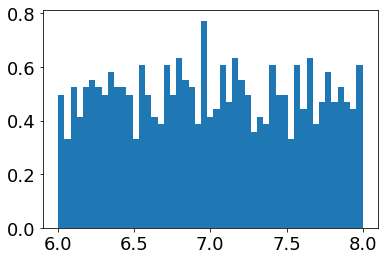

In [41]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def hist_plot(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    plt.figure()
    plt.hist(array,abin,density=True)


def gauss_fit(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    hist, bin_edges = np.histogram(array,abin)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    p0 = [np.nanmax(array), np.nanmean(array), np.nanstd(array)]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    hist_fit = gauss(abin, *coeff)
    plt.figure()
    plt.hist(array,abin)
    plt.plot(abin,hist_fit,label='$\mu$ :{mean:.0f}{linebreak}$\sigma$ :{std:.0f}'.format(linebreak='\n',mean =coeff[1],std=coeff[2]))

s_array = S_map_deb.data.flatten()
sigma_s_array = sigma_S_map.data.flatten()

s_array_ind = s_array.copy()
s_array_ind = s_array_ind[::4]
# s_array_ind = np.log(s_array_ind)

sigma_s_array_ind = sigma_s_array.copy()
sigma_s_array_ind = sigma_s_array_ind[::4]

syn_s = np.random.normal(13,10,1000)
selector = (syn_s < 0)
syn_s_error= np.random.uniform(6,8,syn_s.shape[0])
syn_s[selector] = np.nan
syn_s_error[selector]= np.nan

df_s = pd.DataFrame({'syn_s': syn_s,'syn_s_error':syn_s_error})
df_s = df_s.dropna()

# gauss_fit(df['syn_s_error'],100)
hist_plot(df_s['syn_s_error'],50)
# plt.legend()
plt.show()



Synthetic data for column density

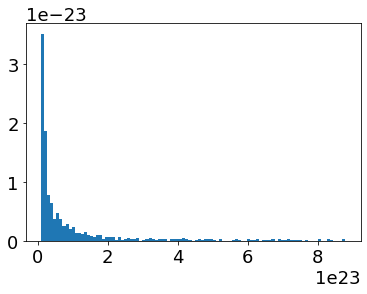

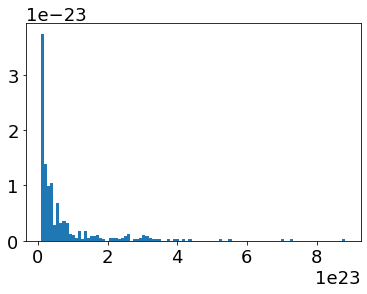

In [68]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

def powerlaw(x,*p):
    a,power = p
    return a*(x**(-1*power))

def syn_error(x):
    return np.random.normal(0,x*0.3,x.shape[0])

nh2_array = BlankedMapColumnDensity.data.flatten()
nh2_array_ind = nh2_array.copy()
nh2_array_ind = nh2_array_ind[::4]
array_min = np.nanmin(nh2_array_ind)
nh2_array_ind = nh2_array_ind

nh2_min = np.nanmin(nh2_array_ind)
nh2_max = np.nanmax(nh2_array_ind)
nh2_bins = np.linspace(nh2_min,nh2_max, 100)

hist, bin_edges = np.histogram(nh2_array_ind,nh2_bins)
temp_alpha = 1 + 1/(np.nanmean(np.log(nh2_array_ind/(np.nanmin(nh2_array_ind)))))
alpha = temp_alpha*0.85
syn_nh2 = rndm(nh2_min,nh2_max, g=(-1*alpha+1), size=syn_s.shape[0])
syn_nh2_error = syn_error(syn_nh2)



hist_plot(syn_nh2,100)
# hist_plot(nh2_array_ind,100)
plt.show()

Synthetic data for Pfrac

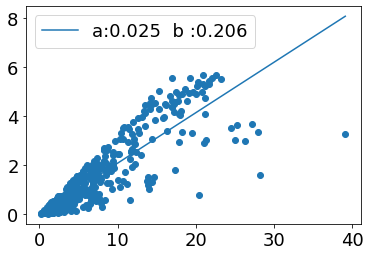

In [72]:
def lin_fit(x, a, b):
    return a + b*x

p_array = BlankedMapPol.data.flatten()
p_error_array = BlankedMapPolError.data.flatten()

p_array_ind = p_array.copy()
p_array_ind = p_array_ind[::4]
p_error_array_ind = p_error_array.copy()
p_error_array_ind = p_error_array_ind[::4]



p_min = np.nanmin(p_array_ind)
p_max = np.nanmax(p_array_ind)
p_bins = np.linspace(p_min, p_max, 150)

selector = ~np.isnan(p_array_ind)
p_array_fil = p_array_ind[selector]
p_error_array_fil = p_error_array_ind[selector]


param, param_cov = curve_fit(lin_fit, p_array_fil, p_error_array_fil)
FitFunc = lin_fit(p_bins,param[0],param[1])


plt.scatter(p_array_fil, p_error_array_fil)
plt.plot(p_bins,FitFunc,label='a:{a:.3f}{linebreak}b :{b:.3f}'.format(linebreak='  ',a =param[0],b=param[1]))
plt.legend()
plt.show()


syn_p_temp = ((syn_s+syn_s_error)**(-1))*((syn_nh2+syn_nh2_error)**(-0.5))
syn_p_error = syn_p_temp*0.206 + 0.025
syn_p = syn_p_temp+syn_p_error

# plt.scatter(syn_p, syn_p_error)
# # plt.plot(p_bins,FitFunc,label='a:{a:.3f}{linebreak}b :{b:.3f}'.format(linebreak='  ',a =param[0],b=param[1]))
# plt.legend()
# plt.show()
